# AA1 Machine learning competition

We'll first install all the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [19]:
from pandas import read_csv

from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import KFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from imblearn.over_sampling import SMOTENC

In [3]:
data = read_csv("liver-patient-classification/train_features_ILDS.csv", delimiter = ',')
data.columns = ["Age", "Female", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]
target = read_csv("liver-patient-classification/train_labels_ILDS.csv")
data["Target"] = target

numerical_columns = ["Age", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]
categorical_columns = ["Female", "Target"]

data[categorical_columns] = data[categorical_columns].astype('category')

print(data[data["Target"]==1].count()[0]/462)

0.2857142857142857


/tmp/ipykernel_5891/1358611933.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data[data["Target"]==1].count()[0]/462)


In [4]:
data.head()

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R,Target
0,48,0,4.5,2.3,282,13,74,7.0,2.4,0.52,0
1,39,0,1.9,0.9,180,42,62,7.4,4.3,1.38,0
2,23,0,1.0,0.3,212,41,80,6.2,3.1,1.00,0
3,42,1,0.7,0.2,152,35,81,6.2,3.2,1.06,0
4,52,1,0.6,0.1,194,10,12,6.9,3.3,0.90,1


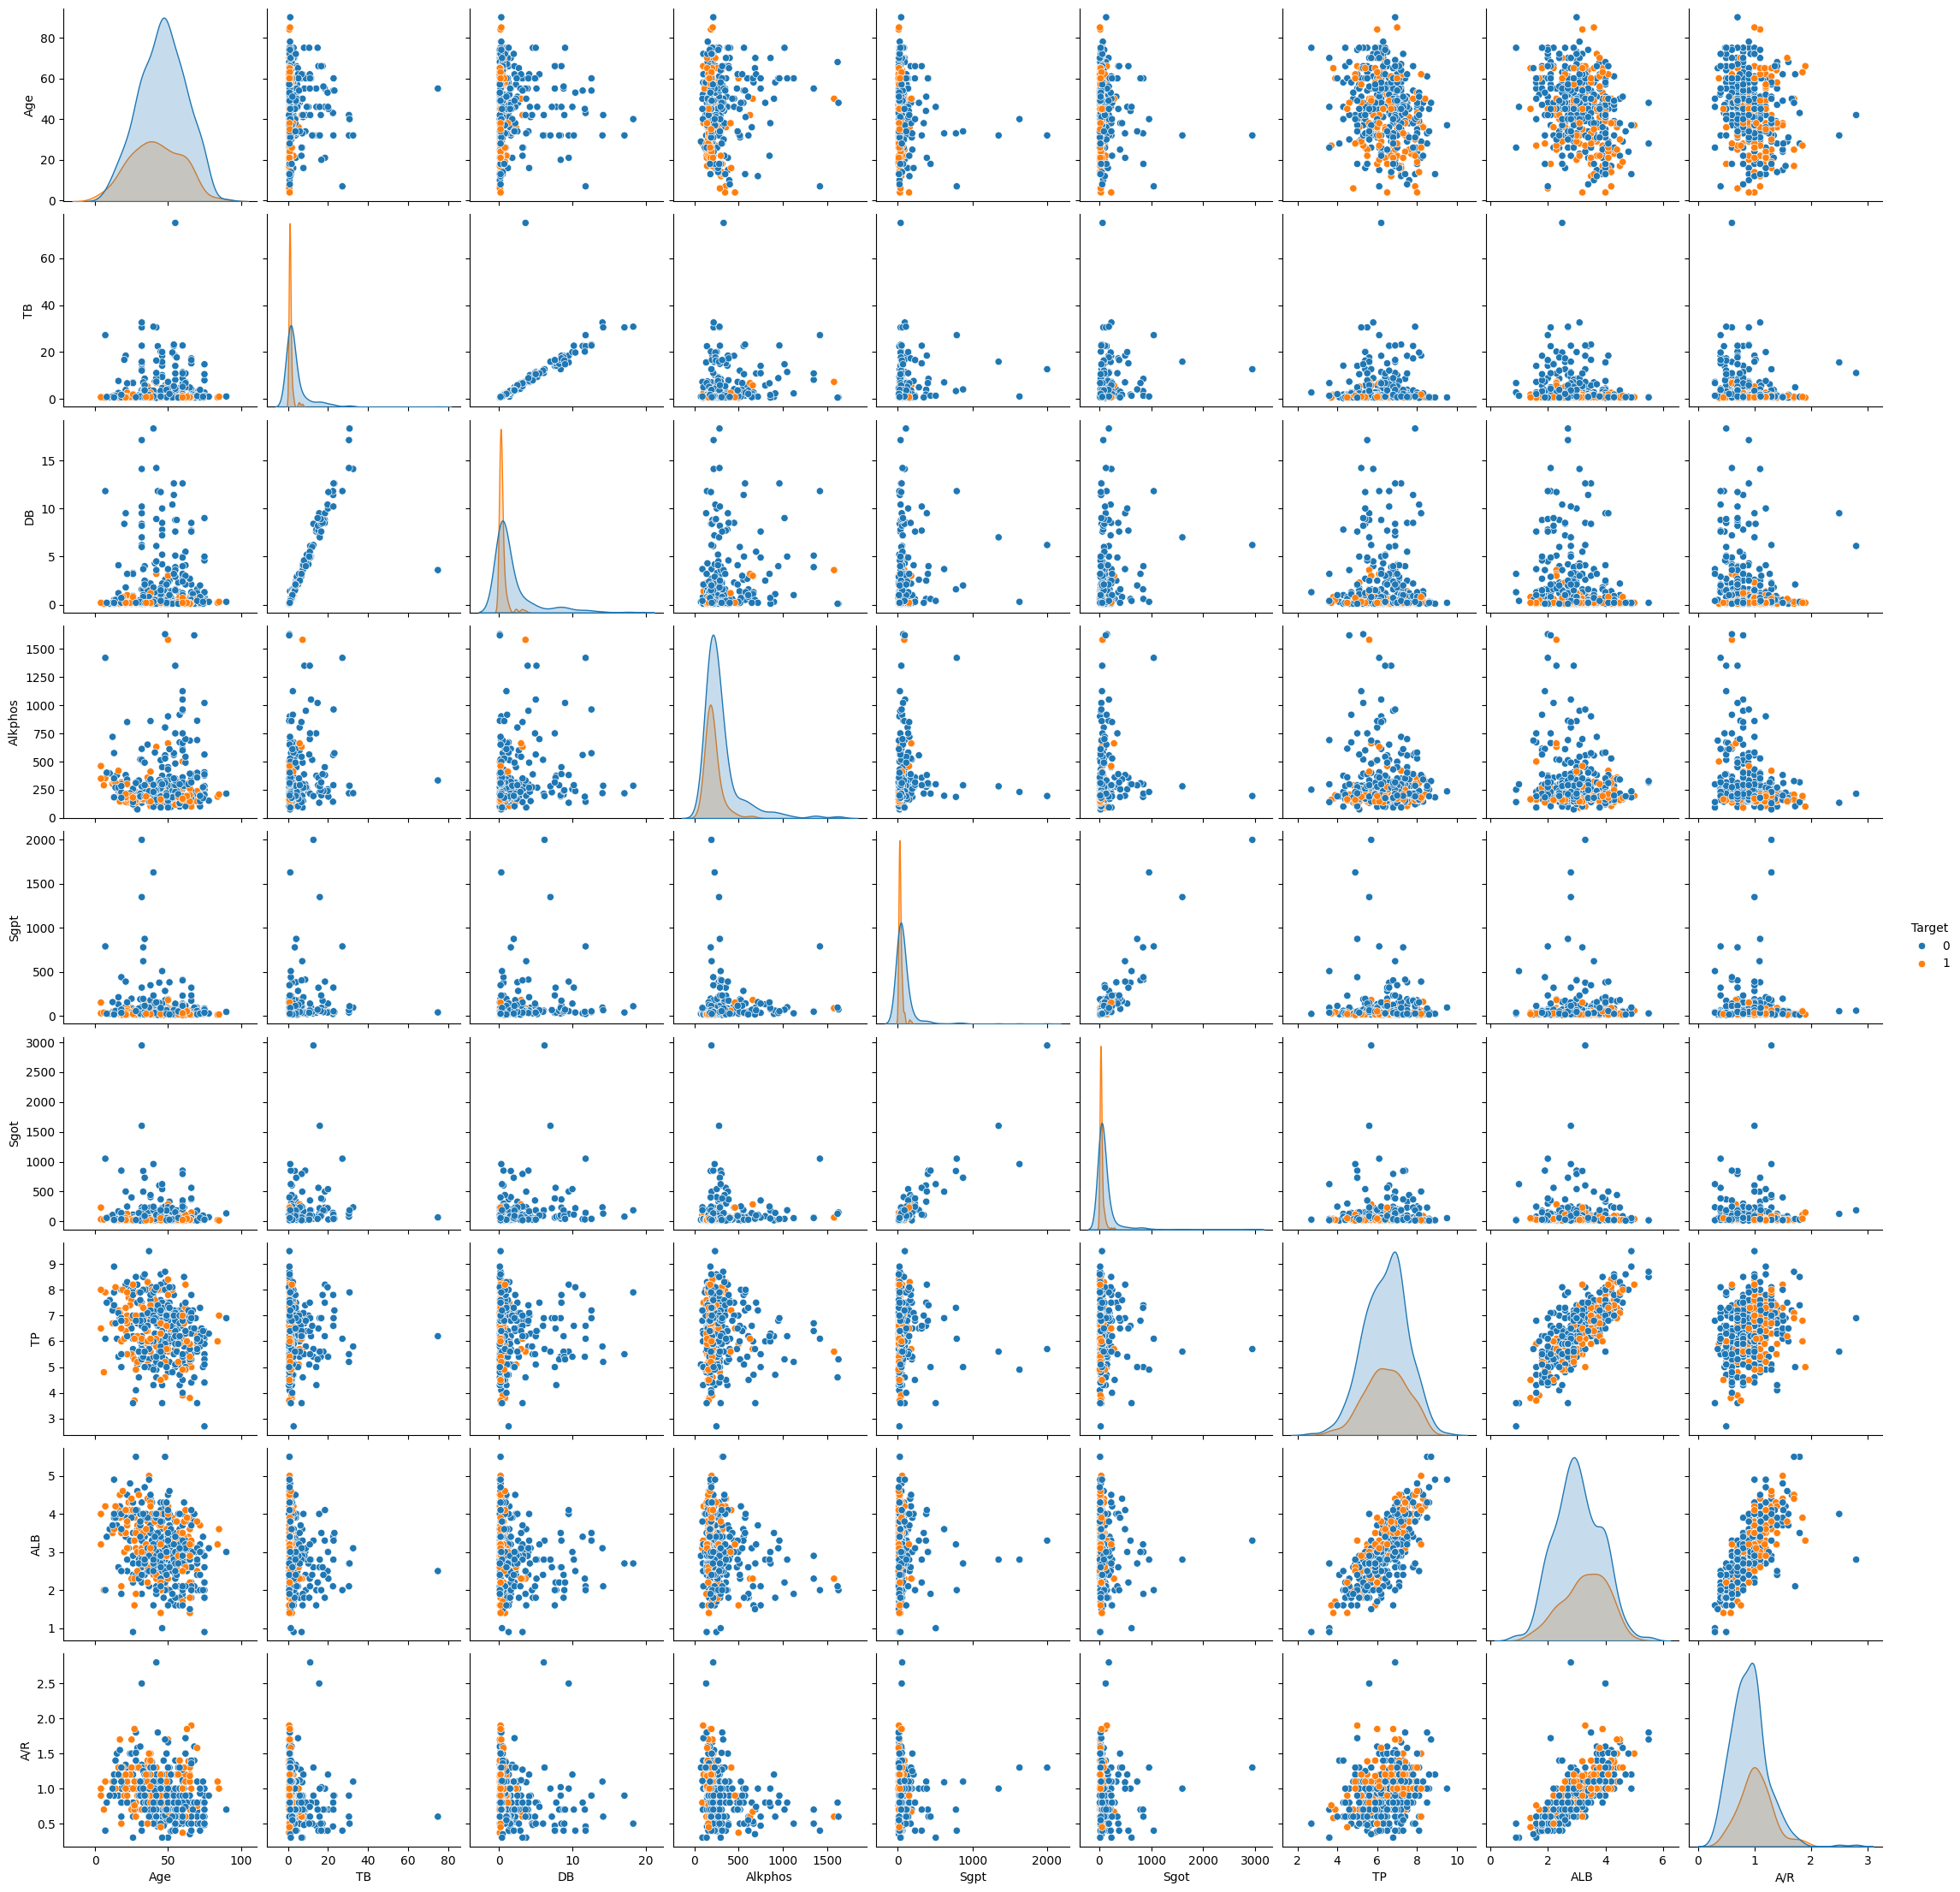

In [5]:
sns.pairplot(data=data, hue="Target")

## Outlier Treatment

We'll use the LocalOutlierFactor model, which considers individuals with a low density of neighbours as outliers. To perform this analysis, we need to be careful with two things. The first is the scale of the variables, as this model depends on the wuclidean distance between samples. Therefore we created a RobustScaler model and modified the the numerical columns of the whole dataset. The other thing to bear in mind is to not reomve many positive cases. This is because being an outlier in the overall dataset may be correlated with a positive case. We consider our analysis to behave well with the unbalanced problem if the proportion of positives we remove is less than the initial proportion of positives.

In [15]:
OutlierScaler = RobustScaler()
ScaledOutlierX = OutlierScaler.fit_transform(data[numerical_columns])


local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
result = local_outlier_factor.fit_predict(ScaledOutlierX)

outliers = result==-1
no_outliers = result == 1
print(f'The model determined that there are {np.sum(outliers)} outliers')
print(f'The number of positive cases removed is {data[outliers & (data["Target"]==1)].count()[0]}')
print(data[outliers])

NO_data = data[no_outliers]

The model determined that there are 24 outliers
The number of positive cases removed is 2
     Age Female    TB    DB  Alkphos  Sgpt  Sgot   TP  ALB   A/R Target
21    33      0   7.1   3.7      196   622   497  6.9  3.6  1.09      0
71    58      0   0.4   0.1      100    59   126  4.3  2.5  1.40      0
85    44      1   1.9   0.6      298   378   602  6.6  3.3  1.00      0
89    60      0   8.6   4.0      298   412   850  7.4  3.0  0.60      0
123   21      0   3.9   1.8      150    36    27  6.8  3.9  1.34      0
137   60      0   6.8   3.2      308   404   794  6.8  3.0  0.70      0
155   33      0   3.4   1.6      186   779   844  7.3  3.2  0.70      0
161   75      0   2.8   1.3      250    23    29  2.7  0.9  0.50      0
171   48      0   0.7   0.2      326    29    17  8.7  5.5  1.70      0
174   50      0   7.3   3.6     1580    88    64  5.6  2.3  0.60      1
181   18      0   1.4   0.6      215   440   850  5.0  1.9  0.60      0
204   48      0   0.7   0.1     1630    74   1

/tmp/ipykernel_5891/136066189.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The number of positive cases removed is {data[outliers & (data["Target"]==1)].count()[0]}')


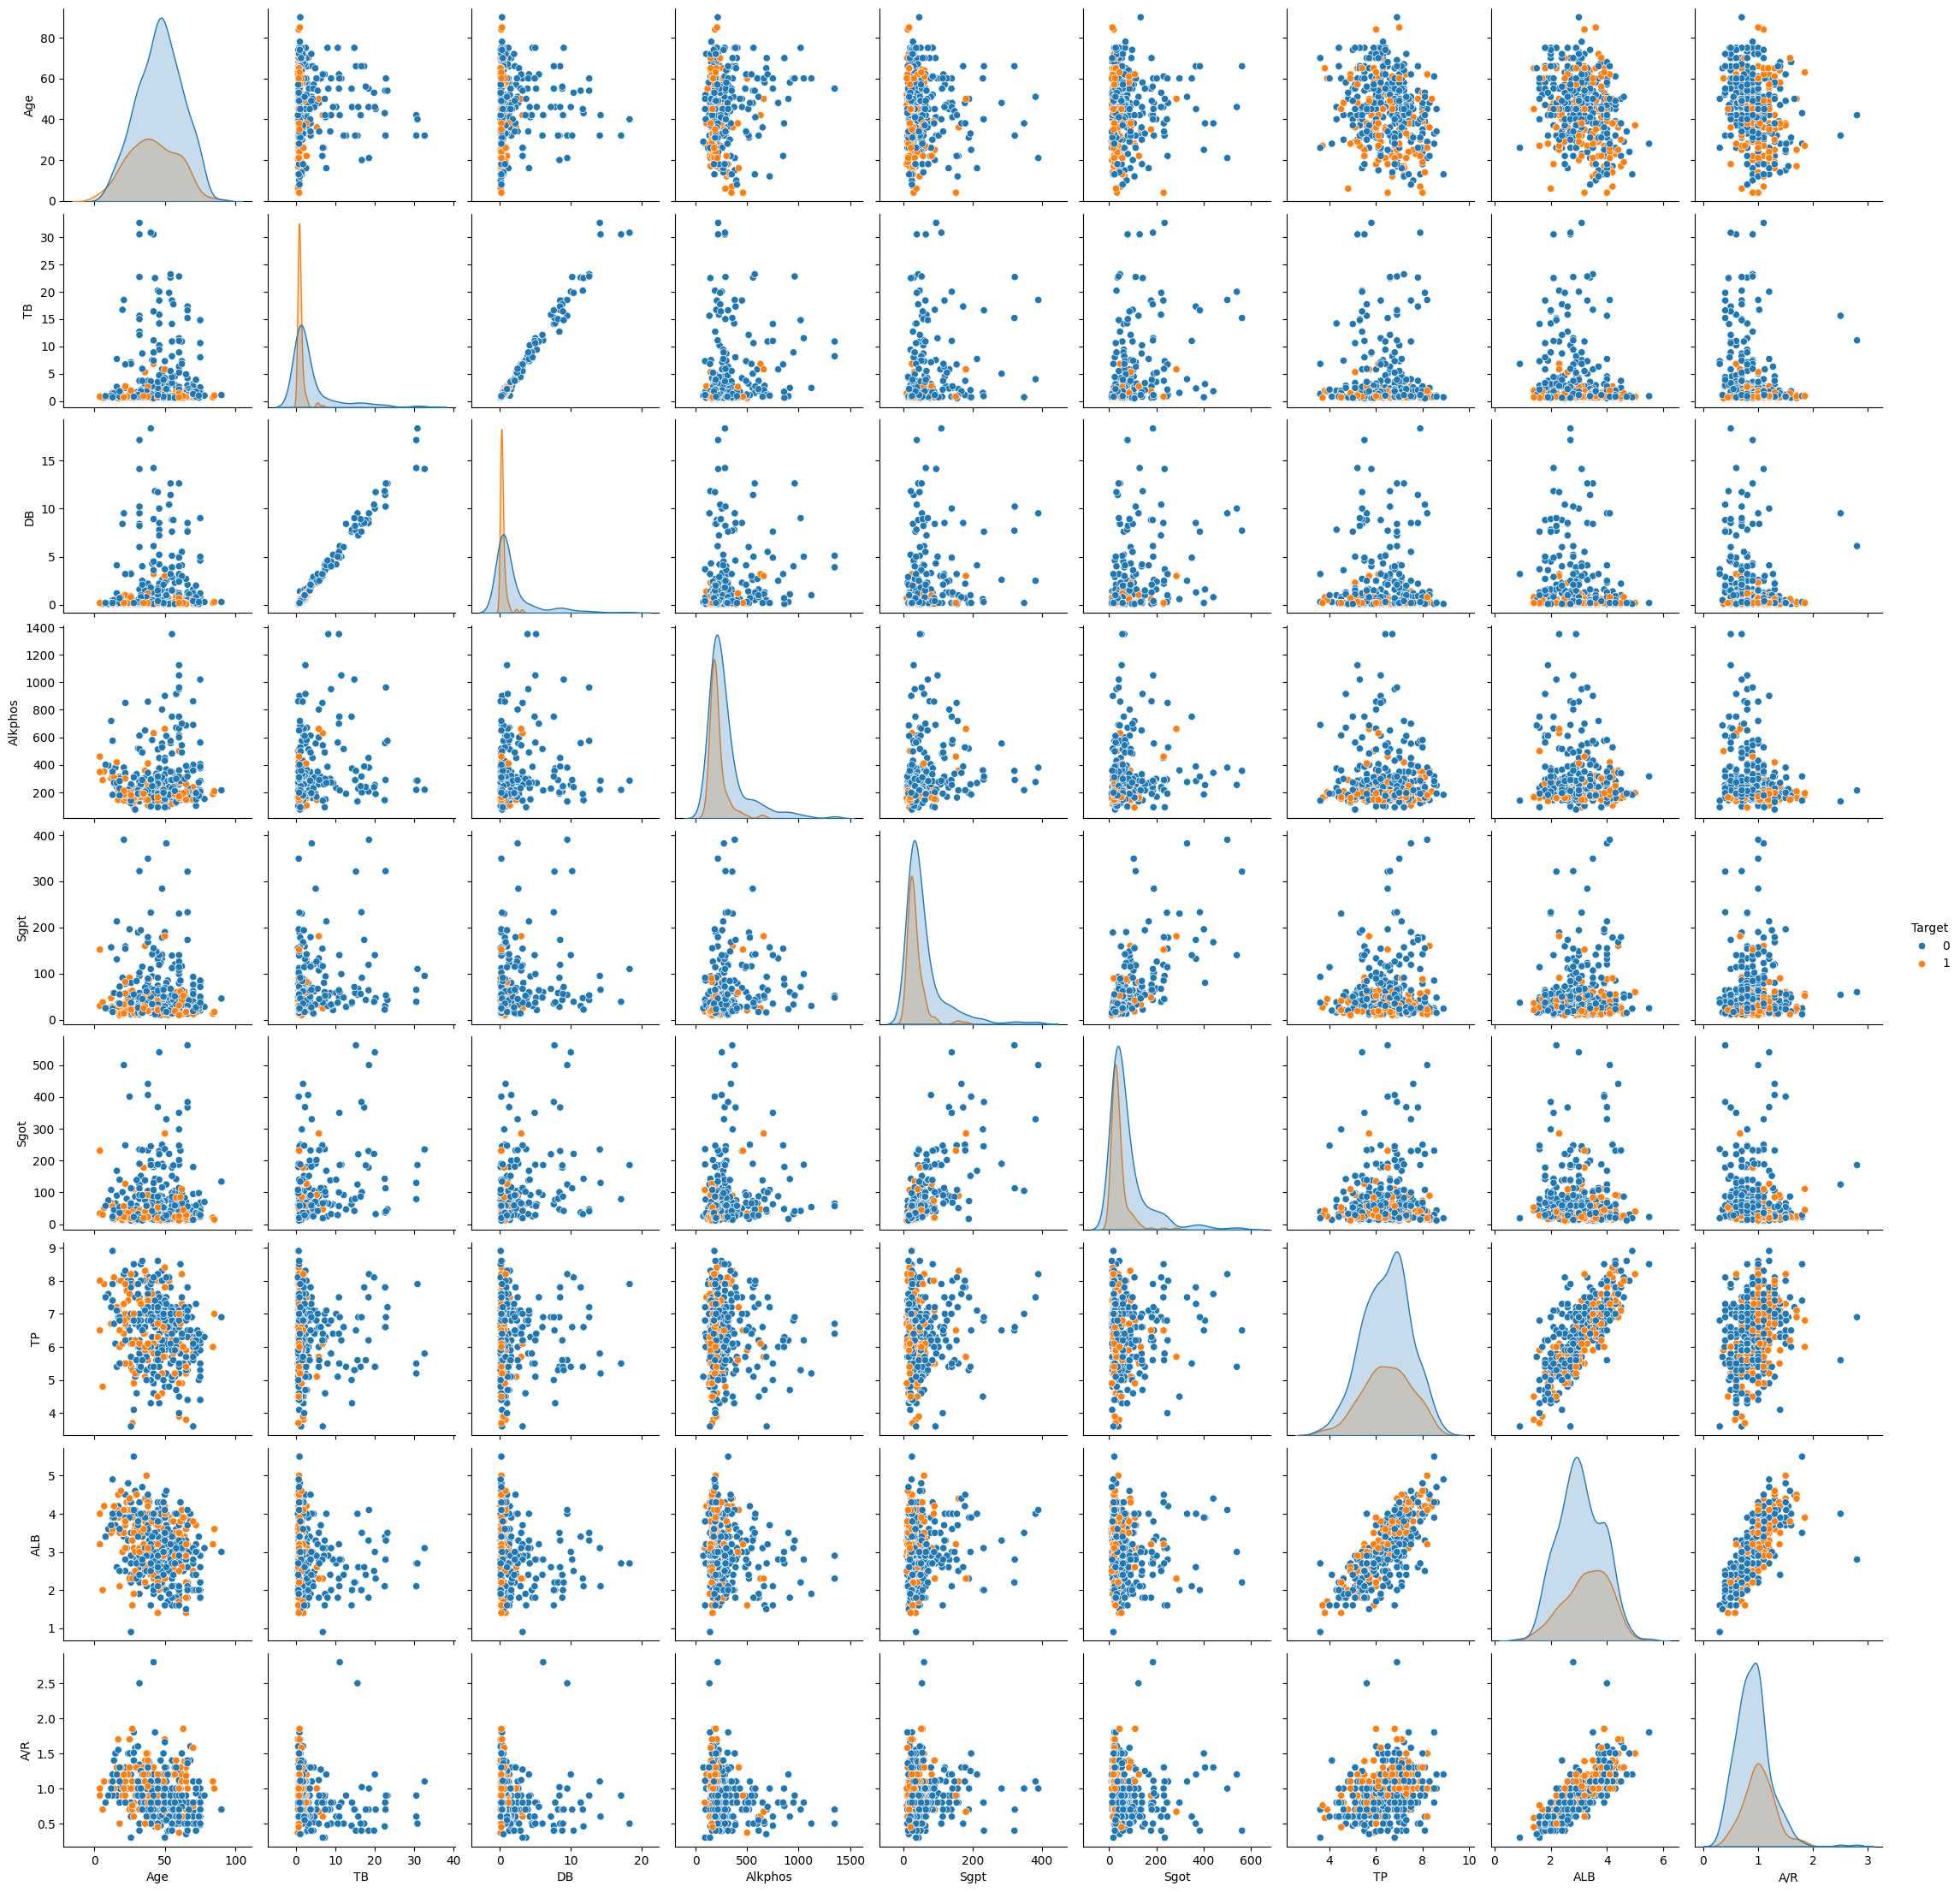

In [7]:
sns.pairplot(data=data[no_outliers], hue="Target")

# Preprocessing
Aquí posem el preprocessing un cop fet els outliers. És a dir, treure correl·lacions, assegurar gaussianitat i escalar.
Això ho farem amb una funció.

In [21]:
def preprocessing(X, y, linModel = None, PwrModel = None, Scaler = None):
    X["Female"] = X["Female"].astype(int)
    y = y.astype(int)

    # Creating the regression with TB and DB
    if linModel is None:
        linModel = LinearRegression().fit(X[["TB"]], X["DB"])
    residual = X["DB"] - linModel.predict(X[["TB"]])
    X["DB_residual"] = residual
    X.drop("DB", axis=1, inplace=True)

    numerical_columns = ["Age", "TB", "DB_residual", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]

    # Applying a yeo-johnson transformation to the data
    if PwrModel is None:
        PwrModel = PowerTransformer(method='yeo-johnson')
        PwrModel.fit(X[numerical_columns])
    X[numerical_columns] = PwrModel.transform(X[numerical_columns])

    # Scaling the data
    if Scaler is None:
        Scaler = MinMaxScaler()
        Scaler.fit(X[numerical_columns])
    X[numerical_columns] = Scaler.transform(X[numerical_columns])

    return X, y, linModel, PwrModel, Scaler

In [9]:
X = NO_data.copy()
X.drop("Target", axis=1, inplace=True)
y = NO_data["Target"]

X, y, linModel, PwrModel, Scaler = preprocessing(X, y)
sns.pairplot(data=X)

NameError: name 'LinearRegression' is not defined

## Correlation between columns

Looking at the previous pairplot, there seems to be a really big correlation between columns `TB` and `DB`, which makes sense as both of these measure the bilirubin quantity in blood. This collinearity might increase the variance of some linear models, so we fit a linear model between these two columns. Then, we substitute `DB` by `DB_residual`, which is the difference between the real Direct Bilirubin and the model's prediction given `TB`.

In [ ]:
print(f'Correlation between the columns: {NO_data["TB"].corr(NO_data["DB"])}. We need it to be bigger than 0.9')

reg = LinearRegression().fit(NO_data[["TB"]], NO_data["DB"])
residual = NO_data["DB"] - reg.predict(NO_data[["TB"]])
NO_data["DB_residual"] = residual

#numerical_columns = ["Age", "TB", "DB_residual", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]
NO_data.drop("DB", axis=1, inplace=True)

# Oversampling Strategy
We'll first try SMOTENC on imblearn. I'll combine this with a Kfold cross-validation to check parameters.

# Method 1

In [10]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [16]:
NO_data.head()

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R,Target
0,48,0,4.5,2.3,282,13,74,7.0,2.4,0.52,0
1,39,0,1.9,0.9,180,42,62,7.4,4.3,1.38,0
2,23,0,1.0,0.3,212,41,80,6.2,3.1,1.00,0
3,42,1,0.7,0.2,152,35,81,6.2,3.2,1.06,0
4,52,1,0.6,0.1,194,10,12,6.9,3.3,0.90,1


In [26]:
X = NO_data.copy()
X.drop("Target", axis=1, inplace=True)
y = NO_data["Target"]

X_train, y_train, linModel, PwrModel, Scaler = preprocessing(X,y)

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

confusion(y_train, pd.Series(model.fit(X_train, y_train).predict(X_train)))

predicted,0,1
target,,
0,188,120
1,26,104
